## Notebook to figure out mesh generation and remeshing
Kernel: remeshing (Python 3.13.9)

In [6]:
# importing the relevant packages
import pyvista as pv
import scipy.spatial as sp
import meshio
import os
import matplotlib.pyplot as plt
import numpy as np
import pygmsh as pg
import jax.numpy as jnp
import gmsh
from units_constants import ConversionFactors as uc


In [7]:
mpath = "./Meshes/"

### Pygmsh meshes
Creating a box with manually defining node coordinates.

In [8]:
x_min = 0.
x_max = 1.
y_min = 0.
y_max = 1.
z_min = 0.
z_max = 1.

with pg.geo.Geometry() as geom:
    # Define points of a cube
    resolution = 0.1
    p0 = geom.add_point([x_min, y_min, z_min], resolution)
    p1 = geom.add_point([x_max, y_min, z_min], resolution)
    p2 = geom.add_point([x_max, y_max, z_min], resolution)
    p3 = geom.add_point([x_min, y_max, z_min], resolution)
    p4 = geom.add_point([x_min, y_min, z_max], resolution)
    p5 = geom.add_point([x_max, y_min, z_max], resolution)
    p6 = geom.add_point([x_max, y_max, z_max], resolution)
    p7 = geom.add_point([x_min, y_max, z_max], resolution)

    # Define lines (12 edges of a cube)
    l01 = geom.add_line(p0, p1)
    l12 = geom.add_line(p1, p2)
    l23 = geom.add_line(p2, p3)
    l30 = geom.add_line(p3, p0)

    l45 = geom.add_line(p4, p5)
    l56 = geom.add_line(p5, p6)
    l67 = geom.add_line(p6, p7)
    l74 = geom.add_line(p7, p4)

    l04 = geom.add_line(p0, p4)
    l15 = geom.add_line(p1, p5)
    l26 = geom.add_line(p2, p6)
    l37 = geom.add_line(p3, p7)

    # Define curve loops and surfaces (6 faces)
    bottom = geom.add_surface(geom.add_curve_loop([l01, l12, l23, l30]))
    top    = geom.add_surface(geom.add_curve_loop([l45, l56, l67, l74]))
    side1  = geom.add_surface(geom.add_curve_loop([l01, l15, -l45, -l04]))
    side2  = geom.add_surface(geom.add_curve_loop([l12, l26, -l56, -l15]))
    side3  = geom.add_surface(geom.add_curve_loop([l23, l37, -l67, -l26]))
    side4  = geom.add_surface(geom.add_curve_loop([l30, l04, -l74, -l37]))

    # Create surface loop and volume
    surface_loop = geom.add_surface_loop([side4, top, side1, bottom, side3, side2]) # order doesn't matter here, it does for the stuff before
    volume = geom.add_volume(surface_loop)

    # Generate 3D mesh
    mesh = geom.generate_mesh()

    # Optional: Save
    mesh.write(mpath+"box.stl")

mesh = pv.read(mpath+"box.stl")

Warning: STL can only write triangle cells. Discarding vertex, tetra, line.

### Creating triangles/tetrahedron cells with Delauney triangulation (`scipy`)
Using the `Delauney` function from `Scipy` to fill box with triangular cells.

12
12
[[ 7 10 11  4]
 [ 7  3  5  4]
 [ 7  3  5 11]
 [ 7  5 11  4]
 [ 7  9  3 11]
 [ 7  1  3  4]
 [ 7  6  2  0]
 [ 7  3  2  0]
 [ 7  3  8  2]
 [ 7  8  6  2]
 [ 7  9  3  8]
 [ 7  1  3  0]]


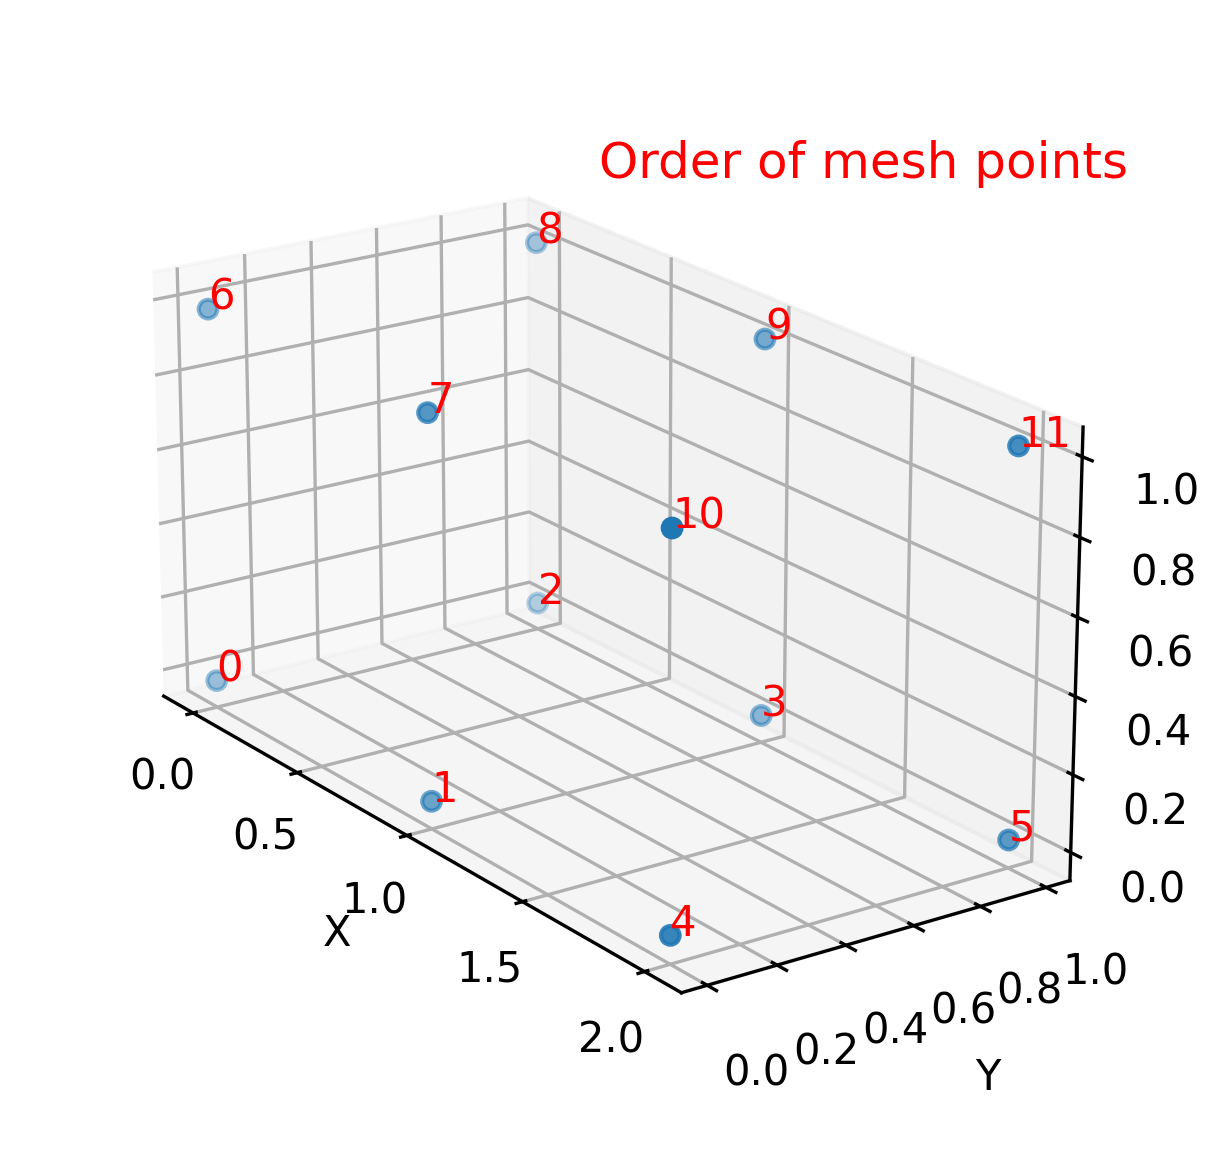

In [9]:
x_max = 2.
y_max = 1.
z_max = 1.

points = np.array([
    [x_min, y_min, z_min],
    [.5*x_max, y_min, z_min],
    [x_min, y_max, z_min],
    [.5*x_max, y_max, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_min, z_max],
    [.5*x_max, y_min, z_max],
    [x_min, y_max, z_max],
    [.5*x_max, y_max, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],])

tetra = sp.Delaunay(points) 
cells = [("tetra", tetra.simplices)]
print(len(points))
print(len(cells[0][1]))
print(tetra.simplices)


mesh = meshio.Mesh(
    points[:6],
    cells[:6],
)
meshio.write_points_cells(mpath+"box_Delauney.vtk", points, cells)
Del_mesh = pv.read(mpath+"box_Delauney.vtk")
Del_mesh

# matplotlib plot of points
Xs = Del_mesh.points[:,0]
Ys = Del_mesh.points[:,1]
Zs = Del_mesh.points[:,2]

# labelled points
ax = plt.figure(dpi = 300).add_subplot(projection='3d')
for i in range (len(Del_mesh.points)):
    ax.text(Del_mesh.points[i,0], Del_mesh.points[i,1], Del_mesh.points[i,2], str(i), color='red')
ax.text(.5*x_max, .5*y_max, z_max + 0.5, "Order of mesh points", color='red', fontsize=12)
ax.scatter(Xs, Ys, Zs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20., azim=-35, roll=0)
ax.set_aspect('equal') # make the grid the same shape as the actual object
plt.show()

# # plotting
# meshio_plot = pv.Plotter()
# meshio_plot.add_mesh(Del_mesh, show_edges = True)
# meshio_plot.show_axes()
# meshio_plot.show()
    

Vertex = shape vertices, not the cells \
LInes = lines you can see on the volume boundary \
Triangles = triangles you can see on  \
Tetras = total tetras?

Points = points inside \
Cells = cells total \

### Pygmsh mesh creation
Adapting the `box_mesh_gmsh` function from `jax-FEM` ([link](https://github.com/deepmodeling/jax-fem/blob/main/jax_fem/generate_mesh.py#L192)).\

Objectives:
- understand the function that makes a box
- modify the function/write a new one that constructs other shapes

Correct syntax from pypi: [link](https://pypi.org/project/pygmsh/) 


In [ ]:
# the function from the jax-fem source code, https://github.com/deepmodeling/jax-fem/blob/main/jax_fem/generate_mesh.py#L151

def box_mesh_gmsh(Nx, Ny, Nz, domain_x, domain_y, domain_z, data_dir, ele_type='HEX8', cell_type = 'hexahedron', degree = 1):
    """Generate a box mesh with the help of `gmsh <https://gmsh.info/>`_.
    Some useful links include
    `tutorial_hex <https://gitlab.onelab.info/gmsh/gmsh/-/blob/master/examples/api/hex.py>`_, 
    `tutorial_t1 <https://gitlab.onelab.info/gmsh/gmsh/-/blob/gmsh_4_7_1/tutorial/python/t1.py>`_, 
    `tutorial_t3 <https://gitlab.onelab.info/gmsh/gmsh/-/blob/gmsh_4_7_1/tutorial/python/t3.py>`_.

    04/01/2026: currently only accepts hex cells.
    Parameters
    ----------
    Nx : int
        Number of nodes along x-axis.
    Ny : int
        Number of nodes along y-axis.
    Nz : int
        Number of nodes along z-axis.
    domain_x : float
        Length of side along x-axis.
    domain_y : float
        Length of side along y-axis.
    domain_z : float
        Length of side along z-axis.    
    data_dir : str
        A directory to store the generated mesh.
    ele_type : str
        The type is :attr:`~jax_fem.fe.FiniteElement.ele_type`.
        Accept 'HEX8', 'Hex20'
    cell_type : str
        The compatible string from the ele type for meshio. 
        See https://github.com/nschloe/meshio/blob/9dc6b0b05c9606cad73ef11b8b7785dd9b9ea325/src/meshio/xdmf/common.py#L36%3E
    degree : int
        Degree of the element.

    Returns
    -------
    out_mesh : MeshioMesh
        Mesh in meshio format.
    """

    # assert ele_type != 'HEX20', f"gmsh cannot produce HEX20 mesh?"

    # cell_type = get_meshio_cell_type(ele_type)
    """ get_elements uses the basix library (of FEniCs?) to retrieve a bunch of element info, of which just
    the degree is used in this particular function. So at least for now, no need to copy that code. 
    """
    #_, _, _, _, degree, _ = get_elements(ele_type) 
    msh_dir = os.path.join(data_dir, 'msh')
    os.makedirs(msh_dir, exist_ok=True)
    msh_file = os.path.join(msh_dir, 'box.msh')

    offset_x = 0.
    offset_y = 0.
    offset_z = 0.

    gmsh.initialize()
    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)  # save in old MSH format

    Rec2d = True
    Rec3d = True
    p = gmsh.model.geo.addPoint(offset_x, offset_y, offset_z)
    l = gmsh.model.geo.extrude([(0, p)], domain_x, 0, 0, [Nx], [1])
    s = gmsh.model.geo.extrude([l[1]], 0, domain_y, 0, [Ny], [1], recombine=Rec2d)
    v = gmsh.model.geo.extrude([s[1]], 0, 0, domain_z, [Nz], [1], recombine=Rec3d)

    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(3)
    gmsh.model.mesh.setOrder(degree)
    gmsh.write(msh_file)
    gmsh.finalize()

    mesh = meshio.read(msh_file)
    points = mesh.points # (num_total_nodes, dim)
    cells =  mesh.cells_dict[cell_type] # (num_cells, num_nodes)
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})

    return out_mesh

out_mesh = box_mesh_gmsh(4,4,4,1,1,1,mpath)



Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Extruded)
Info    : [ 10%] Meshing curve 2 (Extruded)
Info    : [ 20%] Meshing curve 3 (Extruded)
Info    : [ 30%] Meshing curve 4 (Extruded)
Info    : [ 40%] Meshing curve 7 (Extruded)
Info    : [ 50%] Meshing curve 8 (Extruded)
Info    : [ 60%] Meshing curve 9 (Extruded)
Info    : [ 60%] Meshing curve 10 (Extruded)
Info    : [ 70%] Meshing curve 12 (Extruded)
Info    : [ 80%] Meshing curve 13 (Extruded)
Info    : [ 90%] Meshing curve 17 (Extruded)
Info    : [100%] Meshing curve 21 (Extruded)
Info    : Done meshing 1D (Wall 3.8901e-05s, CPU 7.9e-05s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 20%] Meshing surface 14 (Extruded)
Info    : [ 40%] Meshing surface 18 (Extruded)
Info    : [ 60%] Meshing surface 22 (Extruded)
Info    : [ 70%] Meshing surface 26 (Extruded)
Info    : [ 90%] Meshing surface 27 (Extruded)
Info    : Done meshing 2D (Wall 0.000228632s, CPU 0.000433s)
Info    : Meshing 

{'hexahedron': array([[  0,   8,  44,  14,  32,  53,  98,  80],
        [ 32,  53,  98,  80,  33,  54,  99,  81],
        [ 33,  54,  99,  81,  34,  55, 100,  82],
        [ 34,  55, 100,  82,   4,  20,  89,  31],
        [ 14,  44,  45,  15,  80,  98, 101,  83],
        [ 80,  98, 101,  83,  81,  99, 102,  84],
        [ 81,  99, 102,  84,  82, 100, 103,  85],
        [ 82, 100, 103,  85,  31,  89,  90,  30],
        [ 15,  45,  46,  16,  83, 101, 104,  86],
        [ 83, 101, 104,  86,  84, 102, 105,  87],
        [ 84, 102, 105,  87,  85, 103, 106,  88],
        [ 85, 103, 106,  88,  30,  90,  91,  29],
        [ 16,  46,  11,   2,  86, 104,  71,  41],
        [ 86, 104,  71,  41,  87, 105,  72,  42],
        [ 87, 105,  72,  42,  88, 106,  73,  43],
        [ 88, 106,  73,  43,  29,  91,  28,   7],
        [  8,   9,  47,  44,  53,  56, 107,  98],
        [ 53,  56, 107,  98,  54,  57, 108,  99],
        [ 54,  57, 108,  99,  55,  58, 109, 100],
        [ 55,  58, 109, 100,  20,  2

/home/elouan/miniconda3/envs/remeshing/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


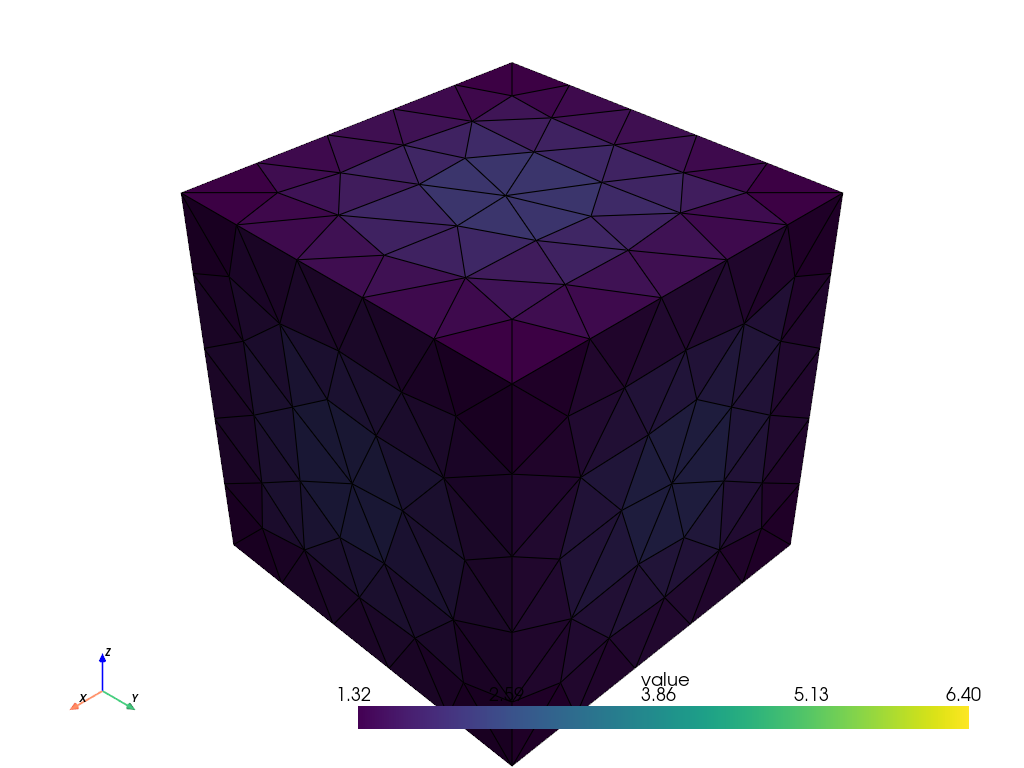

In [46]:
# Step 1: generate the mesh with pygmsh
with pg.occ.Geometry() as geom:
    geom.add_box([.0, .0, .0], [1., 1., 1.], mesh_size = .2) # sphere = ellipsoid with a = b = c
    mesh = geom.generate_mesh()

# a mesh contains all element types, so all lines, vertices, surfaces and cells
# we only add the elements to the meshio mesh that we are interested in, in this case the tetrahedrons
points = mesh.points
tetra_cells = [cell.data for cell in mesh.cells if cell.type == "tetra"]
cells = [("tetra", tetra_cells[0])]

# Compute 1/r falloff at cell centers
center = np.mean(points, axis=0)
cell_centers = np.mean(points[tetra_cells[0]], axis=1)
distances = np.linalg.norm(cell_centers - center, axis=1)
value = 1.0 / np.where(distances == 0, 1e-12, distances)

# Create meshio mesh with cell data
meshio_mesh = meshio.Mesh(
    points=points,
    cells=cells,
    cell_data={"value": [value]}
)

# write meshio mesh to a vtk file
meshio.write(mpath+"cube_coarse.vtk", meshio_mesh)

cube_mesh = pv.read(mpath+"cube_coarse.vtk")

# plotting
pg_plot = pv.Plotter()
pg_plot.add_mesh(cube_mesh, show_edges = True, scalars = "value")
pg_plot.show_axes()
pg_plot.show()

/home/elouan/miniconda3/envs/remeshing/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


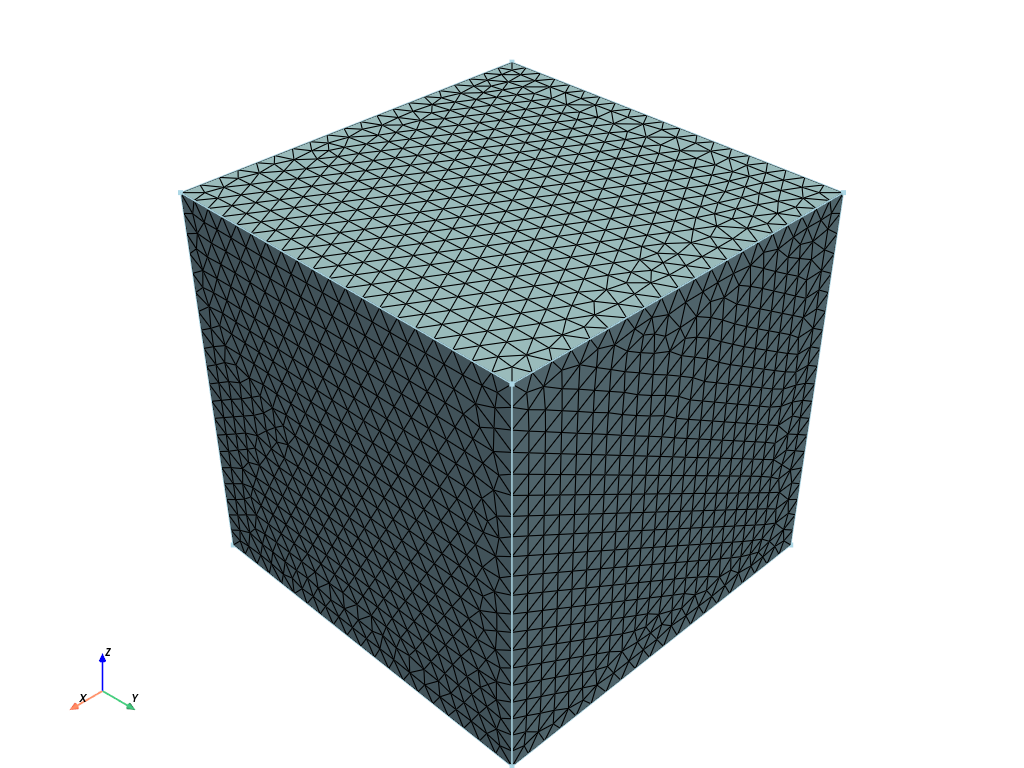

In [47]:
# making another cube
with pg.occ.Geometry() as geom:
    geom.add_box([.0, .0, .0], [1., 1., 1.], mesh_size = .05) 
    mesh = geom.generate_mesh()
points = mesh.points
#print(c_points) 
cells = mesh.cells

# return value is always a meshio mesh.
mesh.write(mpath+"cube_fine.vtk")

cube_mesh = pv.read(mpath+"cube_fine.vtk")

# plotting
pg_plot = pv.Plotter()
pg_plot.add_mesh(cube_mesh, show_edges = True)
pg_plot.show_axes()
pg_plot.show()
    

Gmsh has much more control and customizability, and more options for curves and lines. But may be too intensive for a first prototype. I can always switch to it later.